## Выполнили: Кумин Алексей, Вдовин Евгений
# Лабораторная работа 1 "Управление скоростью вращения DC-мотора"
## 1) Необходимые библиотеки:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np

## 2) Функция для построения тепловых карт:

In [2]:
def create_heat_plot(x, y, z, title, x_label, y_label, fig, ax1, dx, dy):
    #z = z[:-1, :-1]
    levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    #print(levels)
    
    cf = ax1.contourf(x[:-1, :-1] + dx/2.,
                      y[:-1, :-1] + dy/2., z, levels=levels,
                      cmap=cmap)
    #print(cf)
    fig.colorbar(cf, ax=ax1)
    ax1.set_title(title)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    
    fig.tight_layout()

## 3) Теоретическая часть:
* Схематическое представление электромотора постоянного тока и описание принципа его работы
* Вывод математической модели в дифференциальных уравнениях
* Переход к изображениям по Лапласу.
* Коэффициент передачи системы. Что можно сказать по его виду. Построение значения коэффициента передачи от коэффициентов пропорциональности для вращающего момента и индукции в катушке ротора при вращении.
* Построение и анализ АЧХ для системы.
* Построение регулятора скорости вращения. (За что отвечает каждая из компонент ПИД-регулятора, какие компоненты нам нужны?)
* Требования к регулятору (За что отвечает каждое из требований в реальном применении, что будет если они не будут выполняться, как они влияют)
 * Время достижения максимума (время существенного роста)
 * Перерегулирование
 * Время установления
 * Установившаяся статическая ошибка
* Как можно получить значение каждого из критериев на основе данных с датчиков.
* Посторить графики зависимостей каждого из критериев для параметров регулятора (Heat map). Найти "оптимальный" набор значений параметров регулятора.

![scr1.jpg](scr1.jpg)
![scr2.jpg](scr2.jpg)
![scr3.jpg](scr3.jpg)
![scr4.jpg](scr4.jpg)
![scr5.jpg](scr5.jpg)
![scr6.jpg](scr6.jpg)

## 4) Тепловая карта для коэффициента передачи (зависимость K(s) от Km, Kt, пункт 4):


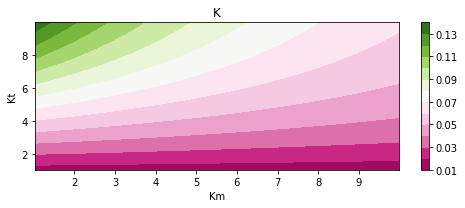

In [10]:
dKm, dKt = 0.05, 0.05

Kt_bounds = (1, 10)
Km_bounds = (1, 10)
Km, Kt = np.mgrid[slice(Km_bounds[0], Km_bounds[1] + dKm, dKm),
                slice(Kt_bounds[0], Kt_bounds[1] + dKt, dKt)]
R = 3.14
J = 10 #0.000015

s = 2
K = Kt/(Kt*Km + R*J*s)
K = K[:-1, :-1]
fig, ax1 = plt.subplots(nrows=1,  figsize=(7,3))
create_heat_plot(Km, Kt, K, "K", "Km", "Kt", fig, ax1, dKm, dKt)

## 5) AЧХ:

Text(0.5, 1.0, 'AЧХ')

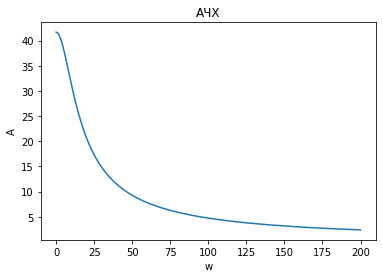

In [19]:
w = np.linspace(0, 200, 10000)

K = 0.024
R = 2.3
J = 0.000022

a = 1 / K
T = R * J / K**2

K = a/np.sqrt(T**2 * w**2 + 1)
plt.plot(w, K)
plt.xlabel("w")
plt.ylabel("A")
plt.title("AЧХ")

## 5) Графики зависимостей критериев (Tp, Mp, Tуст) от параметров ПИ - регулятора Kp, Ki:
В случае когда корни вещественные, время достижения максимума будет бесконечным, а максимум будет равен 1, это можно увижеть на графиках (Tp = 10000, Mp = 1)

In [60]:
def Tpf(A1, w):
    T = np.copy(w)
    for i in range(0, w.shape[0]):
        for j in range(0, w.shape[1]):
            if w[i][j] <= 0:
                T[i][j] = 10000
            else:
                if A1[i][j] > 0:
                    T[i][j] = -np.arctan(1 / A1[i][j] + np.pi) / w[i][j]
                elif A1[i][j] < 0:
                    T[i][j] = -np.arctan(1 / A1[i][j]) / w[i][j]
                else:
                    T[i][j] = (np.pi)/(2 * w[i][j])
    return T           
    
    
def Mpf(t, A3, w, alfa):
    M = np.copy(w)
    for i in range(0, w.shape[0]):
        for j in range(0, w.shape[1]):
            if w[i][j] <= 0:
                M[i][j] = 0
            else:
                M[i][j] = -np.exp(-alfa[i][j] * t[i][j]) * (A3[i][j] * np.sin(w[i][j] * t[i][j]) + np.cos(w[i][j] * t[i][j]))
                M[i][j] *= 100
    return M

#Tуст
def Tyf(A3, alfa):
    T = np.copy(A3)
    for i in range(0, A3.shape[0]):
        for j in range(0, A3.shape[1]):
            T[i][j] = - np.log(0.01 / np.abs(A3[i][j] + 1)) / alfa[i][j]
        
    return T

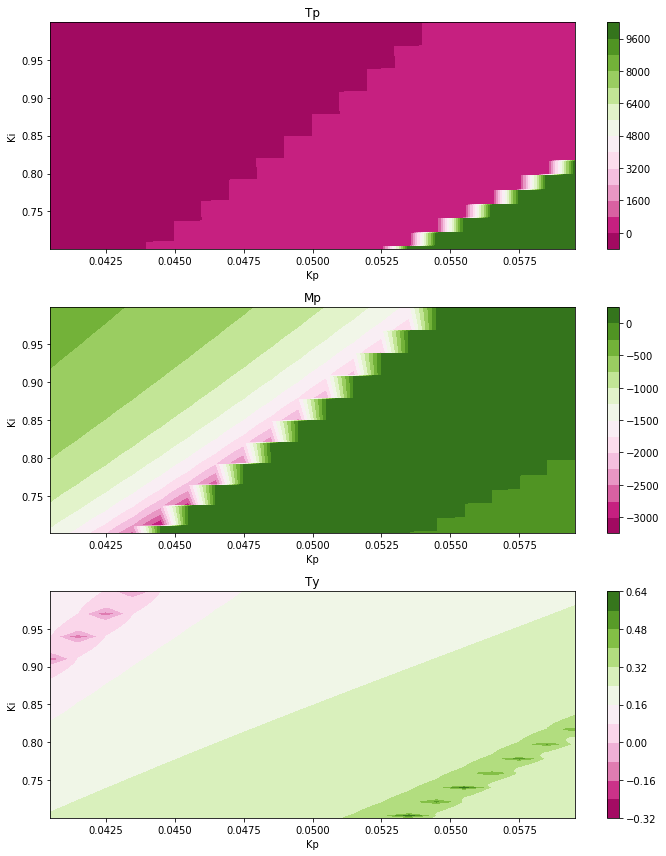

In [62]:
dKp, dKi = 0.001, 0.001

Kp_bounds = (0.04, 0.06)
Ki_bounds = (0.7, 1)
Kp, Ki = np.mgrid[slice(Kp_bounds[0], Kp_bounds[1] + dKp, dKp),
                slice(Ki_bounds[0], Ki_bounds[1] + dKi, dKi)]

alfa = (1 + Kp * a) / (2 * T)
w = Ki * a / T - (alfa)**2

for i in range(0, w.shape[0]):
    for j in range(0, w.shape[1]):
        if w[i][j] > 0:
            w[i][j] = np.sqrt(w[i][j])

            
A1 = (Ki / Kp - alfa) / w
A3 = (1 - alfa) / w


Tp = Tpf(A1, w)
Mp = Mpf(Tp, A3, w, alfa)
Ty = Tyf(A3, alfa)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,  figsize=(10,12))



Tp = Tp[:-1, :-1]
create_heat_plot(Kp, Ki, Tp, "Tp", "Kp", "Ki", fig, ax1, dKp, dKi)
Mp = Mp[:-1, :-1]
create_heat_plot(Kp, Ki, Mp, "Mp", "Kp", "Ki", fig, ax2, dKp, dKi)

Ty = Ty[:-1, :-1]
create_heat_plot(Kp, Ki, Ty, "Ty", "Kp", "Ki", fig, ax3, dKp, dKi)

## 5) Практическая  часть:
* Идентификация параметров электромотора (какие параметры, каким образом оцениваются)
* Валидация оценненых значений параметров (на что влияет каждый из параметров, как нужно менять параметры при разных расхождениях модели и реального объекта, откуда возникают эти расхождения)
* Испытания ПИ-регулятора скорости вращения. Почему регулятор удовлетворяющий выдвинутым требованиям не всегда даёт нужный результат?

![scr7.jpg](scr7.jpg)

### 2) Валидация параметров:
1) Как видно, среднеквадратичная ошибка D(Rm) и D(Km) достаточно не велики, и параметры оценены достаточно хорошо
2) На расхождение модели с реальным обьектом могут вляить условия среды и несовершенность регулятора и приборов, а на оценку параметров погрешность измерений.
3) За что отвечают данные параметры Rm, Km было описано в предыдущем пункте
### 3) Испытание Пи регулятра:
Ниже представлен функционал, позволяющий определить при каких параметрах Ki, Kp из данной области будут выполняться заданные ограничения для характеристик функции отклика Tp < Tp0, Mp < Mp0(%), Ty < Ty0 
Зеленым показаны области, где будут выполнятся данные условия

In [69]:
def Tpf1(A1, w, Tp0):
    T = np.copy(w)
    for i in range(0, w.shape[0]):
        for j in range(0, w.shape[1]):
            if w[i][j] <= 0:
                T[i][j] = 10000
            else:
                if A1[i][j] > 0:
                    T[i][j] = -np.arctan(1 / A1[i][j] + np.pi) / w[i][j]
                elif A1[i][j] < 0:
                    T[i][j] = -np.arctan(1 / A1[i][j]) / w[i][j]
                else:
                    T[i][j] = (np.pi)/(2 * w[i][j])
            if (T[i][j] >= 0) and (T[i][j] < Tp0):
                T[i][j]=10000
            else:
                T[i][j] = 0
    return T           
    
    
def Mpf1(t, A3, w, alfa, Mp0):
    M = np.copy(w)
    for i in range(0, w.shape[0]):
        for j in range(0, w.shape[1]):
            if w[i][j] <= 0:
                M[i][j] = -10000
            else:
                M[i][j] = -np.exp(-alfa[i][j] * t[i][j]) * (A3[i][j] * np.sin(w[i][j] * t[i][j]) + np.cos(w[i][j] * t[i][j]))
                M[i][j] *= 100
            if (M[i][j] >= 0) and (M[i][j] < Mp0):
                M[i][j]=10000
            else:
                M[i][j] = 0
    return M

#Tуст
def Tyf1(A3, alfa, Ty0):
    T = np.copy(A3)
    for i in range(0, A3.shape[0]):
        for j in range(0, A3.shape[1]):
            T[i][j] = - np.log(0.01 / np.abs(A3[i][j] + 1)) / alfa[i][j]
            if (T[i][j] >= 0) and (T[i][j] < Ty0):
                T[i][j]=10000
            else:
                T[i][j] = 0
    return T

def Union(Tp, Mp, Ty):
    Uni = np.copy(Tp)
    for i in range(0, Tp.shape[0]):
        for j in range(0, Tp.shape[1]):
            if (Tp[i][j] > 0) and (Mp[i][j] > 0) and (Ty[i,j] > 0):
                Uni[i][j]=10000
            else:
                Uni[i][j] = 0
    return Uni

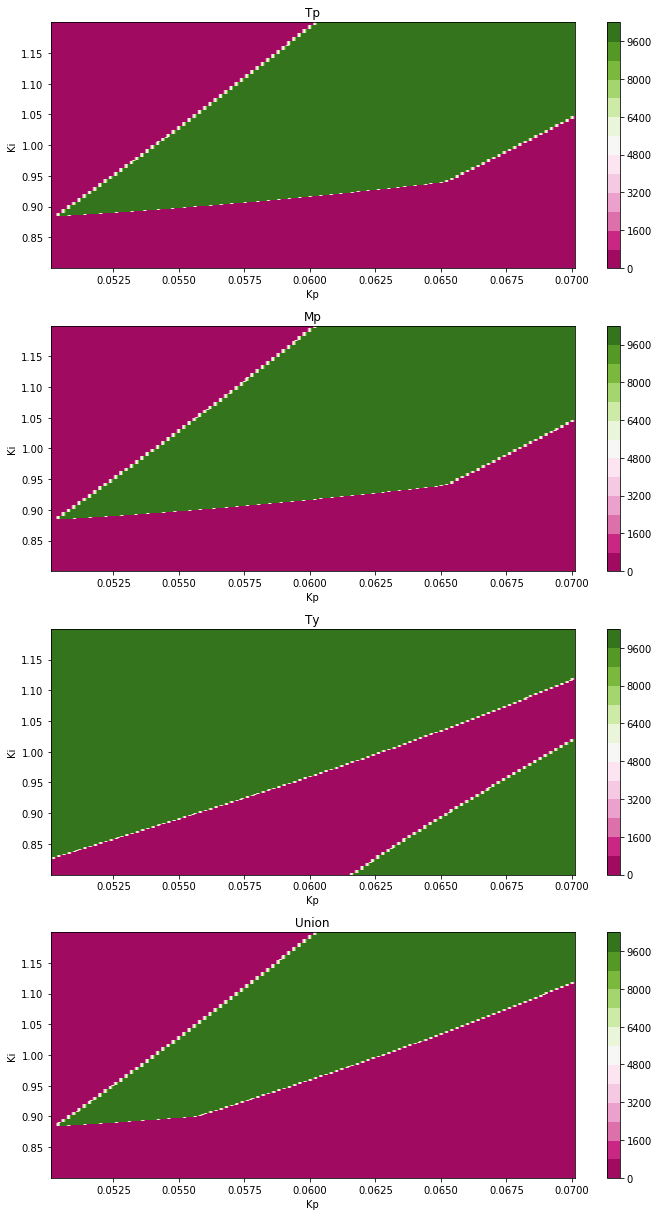

In [71]:
dKp, dKi = 0.0002, 0.0002
Tp0 = 0.15
Mp0 = 5
Ty0 = 0.25

Kp_bounds = (0.05, 0.07)
Ki_bounds = (0.8, 1.2)
Kp, Ki = np.mgrid[slice(Kp_bounds[0], Kp_bounds[1] + dKp, dKp),
                slice(Ki_bounds[0], Ki_bounds[1] + dKi, dKi)]

alfa = (1 + Kp * a) / (2 * T)
w = Ki * a / T - (alfa)**2

for i in range(0, w.shape[0]):
    for j in range(0, w.shape[1]):
        if w[i][j] > 0:
            w[i][j] = np.sqrt(w[i][j])

            
A1 = (Ki / Kp - alfa) / w
A3 = (1 - alfa) / w


Tp = Tpf1(A1, w, Tp0)
Mp = Mpf1(Tp, A3, w, alfa, Mp0)
Ty = Tyf1(A3, alfa, Ty0)
Uni = Union(Tp, Mp, Ty)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,  figsize=(10,17))



Tp = Tp[:-1, :-1]
create_heat_plot(Kp, Ki, Tp, "Tp", "Kp", "Ki", fig, ax1, dKp, dKi)
Mp = Mp[:-1, :-1]
create_heat_plot(Kp, Ki, Mp, "Mp", "Kp", "Ki", fig, ax2, dKp, dKi)
Ty = Ty[:-1, :-1]
create_heat_plot(Kp, Ki, Ty, "Ty", "Kp", "Ki", fig, ax3, dKp, dKi)
Uni = Uni[:-1, :-1]
create_heat_plot(Kp, Ki, Uni, "Union", "Kp", "Ki", fig, ax4, dKp, dKi)


# Лабораторная работа 2 "Управление углом поворота DC-мотора"
## 1) Теоретическая  часть:
![scr8.jpg](scr8.jpg)
![scr9.jpg](scr9.jpg)
![scr10.jpg](scr10.jpg)
![scr11.jpg](scr11.jpg)
![scr12.jpg](scr12.jpg)
![scr13.jpg](scr13.jpg)
![scr14.jpg](scr14.jpg)
![scr15.jpg](scr15.jpg)
![scr16.jpg](scr16.jpg)